In [1]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 

dataset = torch.load('data/eit-circles-dtn-default-128.pt', map_location='cpu')

# Load DEFAULT mesh as requested
data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
mat_fname = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

dtn_background = dtn_from_sigma(sigma_vec=torch.ones(128, 128), v_h=v_h, mesh=mesh, img_size=128, device=device).cpu()

train_X = dataset['train']['dtn_map'].float()
train_X /= dtn_background
train_Y = dataset['train']['media'].float()

train_X_min = train_X.min()
train_X_max = train_X.max()
train_Y_min = train_Y.min()
train_Y_max = train_Y.max()

cwd = /home/johnma/flow-inverse


In [2]:
from models.conditional_models import ConditionalConcatUnet

model = ConditionalConcatUnet(unet_ch=32).to(device)

checkpoint = torch.load(
    "saved_runs/circles-eit-concat-unet-flow-default-bg-transform_ot_3/checkpoints/ckp_31500.tar",
    map_location=device,
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConditionalConcatUnet(
  (unet): Unet(
    (input_proj): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResBlock(
          (skip_connection): Identity()
          (block1): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Identity()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (block2): Sequential(
            (0): GroupNorm(32, 32, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (cond_block): ConditioningBlock(
            (proj): Sequential(
            

Sampling:   0%|          | 0/32 [00:00<?, ?it/s]

Relative L2 Error Statistics:
Mean: 0.4327
Std:  0.1049
Min:  0.1466
Max:  0.8027
Median: 0.4299


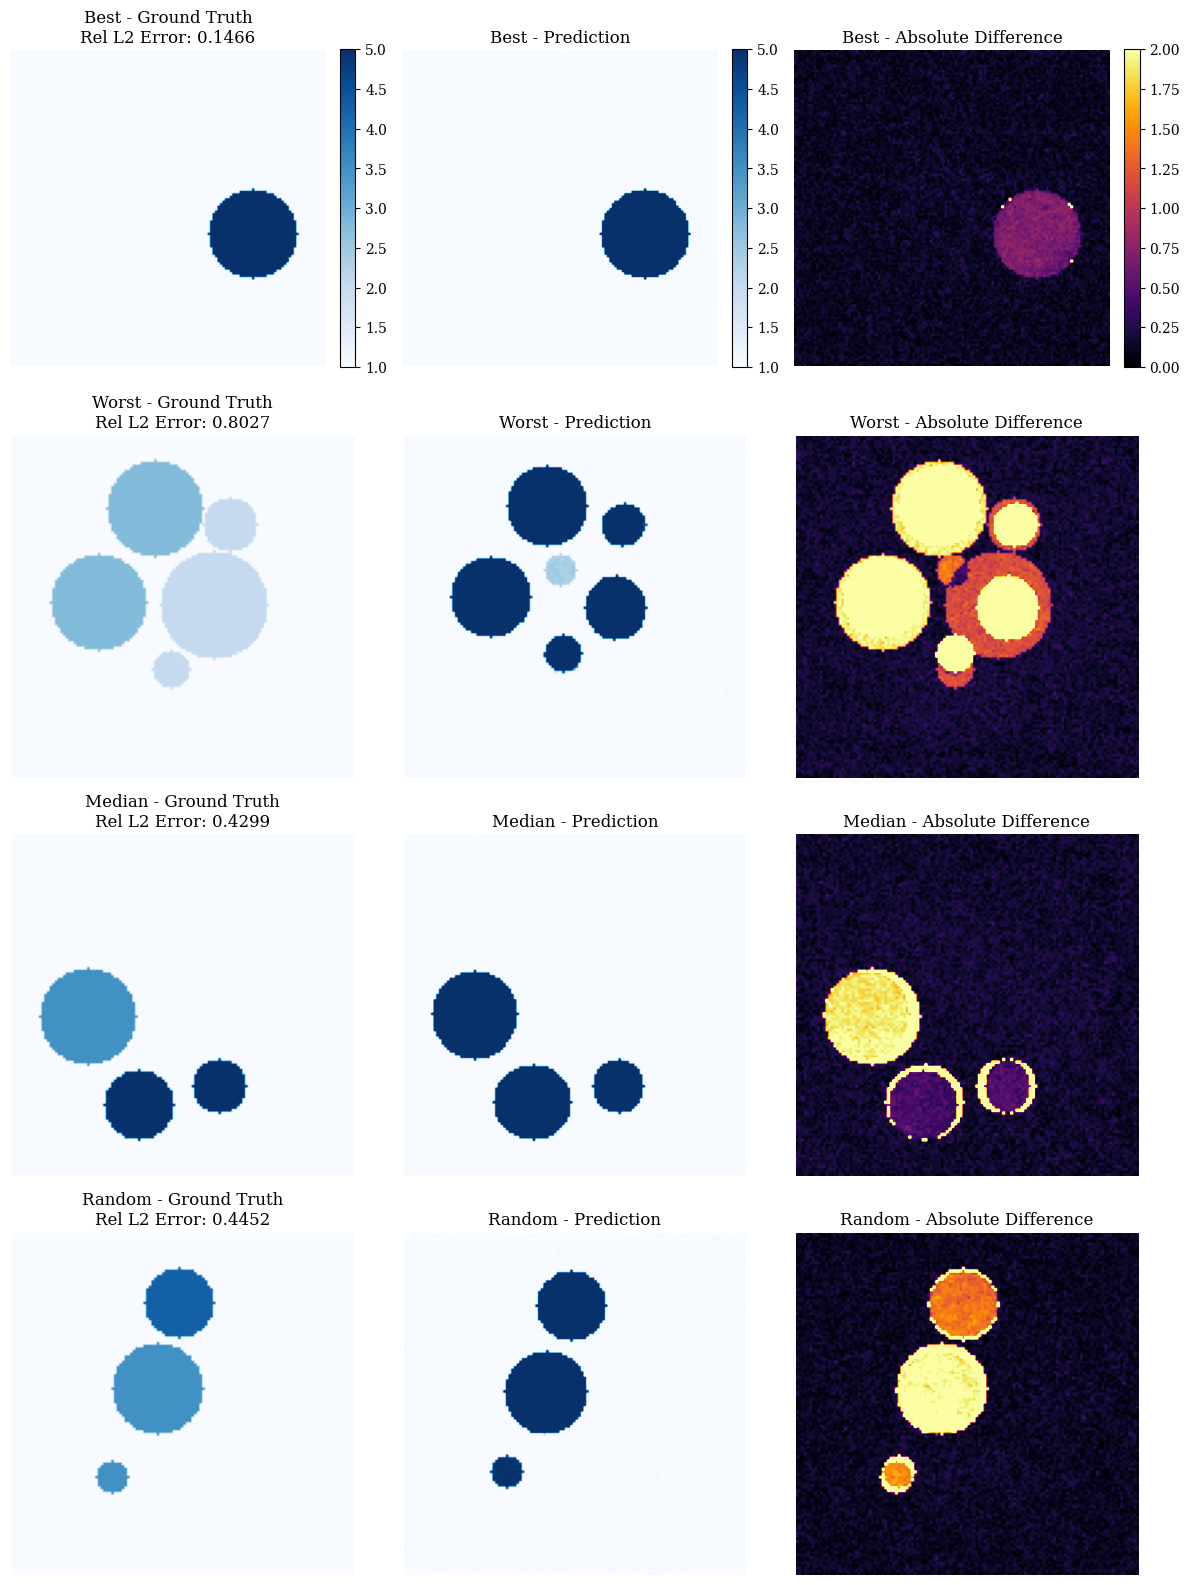

In [3]:
# Batched conditional sampling + evaluation on test data
model.eval()
with torch.no_grad():
    def sample_conditional_from_dtn(cond_dtn: torch.Tensor, *, bs: int = 64) -> torch.Tensor:
        """cond_dtn: (N,1,H,W) in normalized [-1,1] space on CPU or GPU."""
        cond_dtn = cond_dtn.to(device)

        def v_from_x_pred(z, t, cond):
            guidance_scale = 5.0
            t_batch = t.expand(z.shape[0])
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                v_uncond = model(z, torch.zeros_like(cond), t_batch)
                v_cond = model(z, cond, t_batch)
            return v_uncond + guidance_scale * (v_cond - v_uncond)

        timesteps = torch.linspace(0.0, 1.0, steps=5).to(device)

        preds_cpu = []
        for start in tqdm(range(0, cond_dtn.shape[0], bs), desc="Sampling", leave=False):
            cond = cond_dtn[start:start + bs]
            z0 = torch.randn(cond.shape[0], 1, 128, 128, device=device)

            pred_batch = odeint(
                func=lambda t, x: v_from_x_pred(x, t, cond),
                t=timesteps,
                y0=z0,
                method='rk4',
                atol=1e-5,
                rtol=1e-5,
            )[-1]

            preds_cpu.append(pred_batch.detach().cpu())

            del pred_batch, z0, cond
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        predictions = torch.cat(preds_cpu, dim=0).squeeze(1)
        del preds_cpu
        return predictions

    # Build normalized test conditioning tensor (N,1,H,W)
    test_X_eval = dataset['test']['dtn_map'].detach().clone().float()
    test_X_eval /= dtn_background
    test_X_eval = 2.0 * (test_X_eval - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
    test_X_eval = test_X_eval.unsqueeze(1)

    # Sample predictions in normalized space
    predictions = sample_conditional_from_dtn(test_X_eval, bs=64)

    # Denormalize predictions and ground truth
    pred_denorm = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min
    gt_denorm = dataset['test']['media'].float().cpu()

    rel_l2_errors = []
    for i in range(len(pred_denorm)):
        pred = pred_denorm[i].cpu()
        gt = gt_denorm[i]

        error = torch.norm(pred - gt, 2) / torch.norm(gt, 2)
        rel_l2_errors.append(error.item())

    rel_l2_errors = np.array(rel_l2_errors)

    print(f"Relative L2 Error Statistics:")
    print(f"Mean: {rel_l2_errors.mean():.4f}")
    print(f"Std:  {rel_l2_errors.std():.4f}")
    print(f"Min:  {rel_l2_errors.min():.4f}")
    print(f"Max:  {rel_l2_errors.max():.4f}")
    print(f"Median: {np.median(rel_l2_errors):.4f}")

    plt.rcParams["font.family"] = "DejaVu Serif"
    title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

    best_idx = np.argmin(rel_l2_errors)
    worst_idx = np.argmax(rel_l2_errors)
    median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
    random_idx = np.random.randint(len(rel_l2_errors))

    indices_to_plot = [best_idx, worst_idx, median_idx, random_idx]
    titles = ['Best', 'Worst', 'Median', 'Random']

    fig, axes = plt.subplots(4, 3, figsize=(12, 16))
    for i, (idx, title) in enumerate(zip(indices_to_plot, titles)):
        pred = pred_denorm[idx].cpu().numpy()
        gt = gt_denorm[idx].cpu().numpy()
        error = rel_l2_errors[idx]

        im1 = axes[i, 0].imshow(gt, cmap='Blues', vmin=1, vmax=5)
        axes[i, 0].set_title(f'{title} - Ground Truth\nRel L2 Error: {error:.4f}')
        axes[i, 0].axis('off')

        im2 = axes[i, 1].imshow(pred, cmap='Blues', vmin=1, vmax=5)
        axes[i, 1].set_title(f'{title} - Prediction')
        axes[i, 1].axis('off')

        diff = np.abs(pred - gt)
        im3 = axes[i, 2].imshow(diff, cmap='inferno', vmin=0, vmax=2)
        axes[i, 2].set_title(f'{title} - Absolute Difference')
        axes[i, 2].axis('off')

        if i == 0:
            fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
            fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
            fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [4]:
import gc

def evaluate_with_noise(delta, *, bs: int = 64):
    model.eval()
    with torch.no_grad():
        # 1. Load raw DtN maps
        raw_test_X = dataset['test']['dtn_map'].detach().clone().float()

        # 2. Add multiplicative noise pre-transform
        noise_z = torch.randn_like(raw_test_X)
        noisy_test_X = (1 + delta * noise_z) * raw_test_X

        # 3. Apply background transformation
        noisy_test_X /= dtn_background

        # 4. Normalize using training statistics and shape (N,1,H,W)
        noisy_test_X = 2.0 * (noisy_test_X - train_X_min) / (train_X_max - train_X_min + 1e-12) - 1.0
        noisy_test_X = noisy_test_X.unsqueeze(1)

        # 5. Sample via conditional flow matching (batched)
        predictions = sample_conditional_from_dtn(noisy_test_X, bs=bs)

        # 6. Denormalize + compute errors
        pred_denorm = 0.5 * (predictions + 1.0) * (train_Y_max - train_Y_min + 1e-12) + train_Y_min
        test_media_gt = dataset['test']['media'].float().cpu()

        rel_l2_errors = []
        for i in range(len(pred_denorm)):
            p_i = pred_denorm[i].cpu()
            g_i = test_media_gt[i]
            error = torch.norm(p_i - g_i, 2) / torch.norm(g_i, 2)
            rel_l2_errors.append(error.item())

        rel_l2_errors = np.array(rel_l2_errors)
        print(f"Mean Rel L2 Error: {rel_l2_errors.mean():.4f}")

        best_idx = np.argmin(rel_l2_errors)
        worst_idx = np.argmax(rel_l2_errors)
        median_idx = np.argsort(rel_l2_errors)[len(rel_l2_errors) // 2]
        random_idx = np.random.randint(len(rel_l2_errors))

        indices_to_viz = [best_idx, worst_idx, median_idx, random_idx]
        viz_titles = ['Best', 'Worst', 'Median', 'Random']

        plt.rcParams["font.family"] = "DejaVu Serif"
        title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}

        fig, axes = plt.subplots(len(indices_to_viz), 3, figsize=(12, 4 * len(indices_to_viz)))
        fig.suptitle(
            f"Predictions with Noise $\\delta = {delta}$ (Mean Error: {rel_l2_errors.mean():.4f})",
            fontsize=16,
        )

        for i, idx in enumerate(indices_to_viz):
            gt_plot = test_media_gt[idx].cpu().numpy()
            pred_plot = pred_denorm[idx].cpu().numpy()
            diff_plot = np.abs(pred_plot - gt_plot)

            im1 = axes[i, 0].imshow(gt_plot, cmap='Blues', vmin=1, vmax=5)
            axes[i, 0].set_title(f"{viz_titles[i]} - GT\nErr: {rel_l2_errors[idx]:.4f}")
            axes[i, 0].axis('off')

            im2 = axes[i, 1].imshow(pred_plot, cmap='Blues', vmin=1, vmax=5)
            axes[i, 1].set_title(f"Prediction")
            axes[i, 1].axis('off')

            im3 = axes[i, 2].imshow(diff_plot, cmap='inferno', vmin=0, vmax=2)
            axes[i, 2].set_title(f"Abs Difference")
            axes[i, 2].axis('off')

            if i == 0:
                fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
                fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
                fig.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        del raw_test_X, noise_z, noisy_test_X, predictions, pred_denorm
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

Mean Rel L2 Error: 0.4705


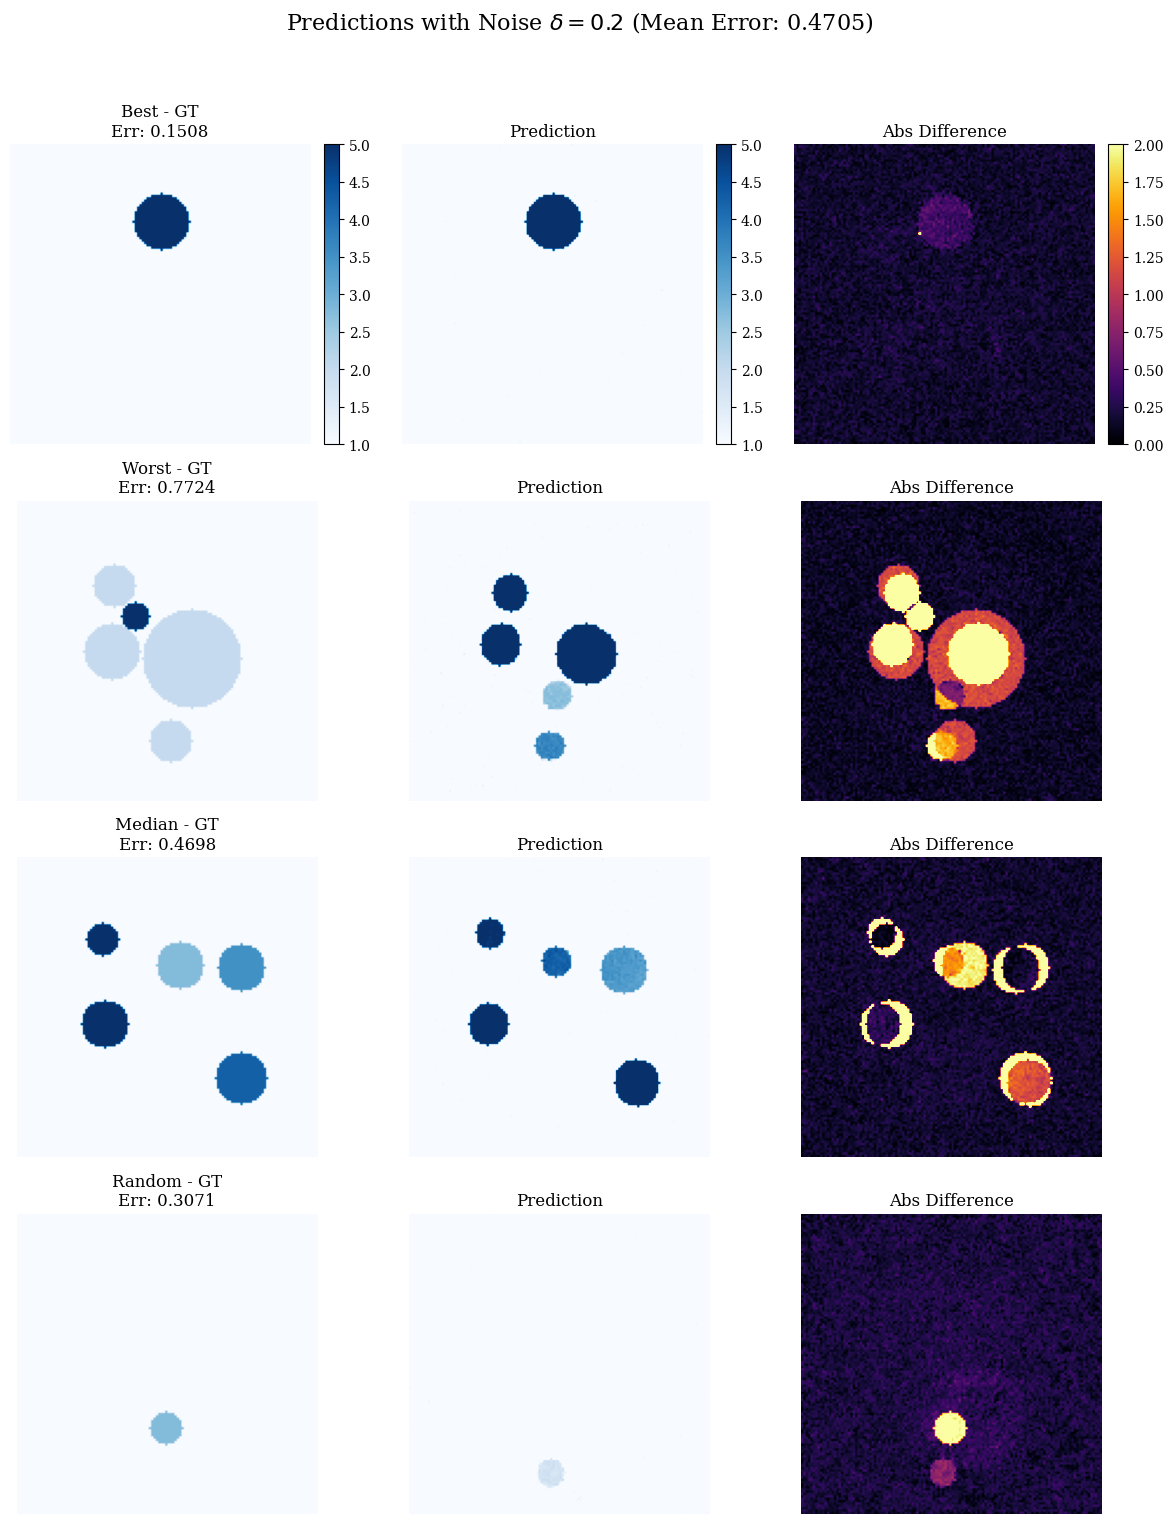

In [5]:
evaluate_with_noise(0.2)